<h1>Handwriting Letter GAN Usage</h1>

<h3>Links</h3>
<ul>
    <li><a href=https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/>cGAN Code</a></li>
    <li><a href=https://keras.io/getting-started/functional-api-guide/>Keras Functional API</a></li>
    <li><a href=<li><a href=https://arxiv.org/pdf/1702.05373.pdf>EMNIST Dataset Paper</a></li>
</ul>

In [10]:
import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt

!git clone https://github.com/Amogh13246831/Handwriting-GAN
!ls

fatal: destination path 'Handwriting-GAN' already exists and is not an empty directory.
Handwriting-GAN  sample_data


In [0]:
def generate_latent_noise(latent_dim, n_samples, n_classes=47):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

In [12]:
gen = load_model('Handwriting-GAN/models/generator.h5')

latent_dim = gen.input[0].shape[1]
print('\n', 'Latent space dimension:', latent_dim, '\n')
gen.summary()


 Latent space dimension: 100 

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 6272)         633472      input_20[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        2350        input_19[0][0]                   
___________________________________________________________

In [0]:
def get_emnist_balanced_dict():
  balanced_dict = {chr(i): i-48 for i in range(48, 58)}
  balanced_dict.update({chr(i): i-55 for i in range(65, 91)})
  balanced_dict.update({'a':36, 'b':37, 'c':12, 'd':38, 'e':39, 'f':40, 'g':41,
                        'h':42, 'i':18, 'j':19, 'k':20, 'l':21, 'm':22, 'n':43,
                        'o':24, 'p':25, 'q':44, 'r':45, 's':28, 't':46, 'u':30,
                        'v':31, 'w':32, 'x':33, 'y':34, 'z':35})
  return balanced_dict

def generate_word_images(word, latent_dim, label_dict):
  labels = np.asarray([label_dict[ch] for ch in word])
  noise, _ = generate_latent_noise(latent_dim, len(word))
  images = np.squeeze(gen.predict([noise, labels]))
  if images.ndim == 2:    # for a single-letter image, consistency of shape
    images = np.asarray([images])
  images = (images + 1) / 2.0
  return images

def show_generated(examples, n, c):
  plt.imshow(np.hstack((examples[:])), cmap='gray_r')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


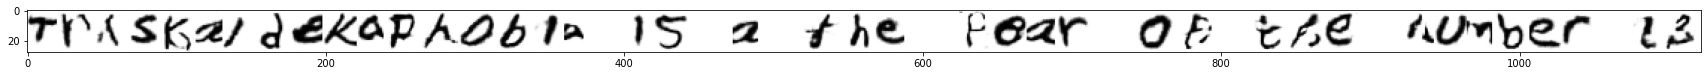

In [14]:
def chop_wsp(image, thresh=0.1):
  ncr = len(image[0]) - 2
  while np.all(image[:][ncr] < thresh): # chop from right
    ncr -= 1
  ncl = 1
  while np.all(image[:][ncl] < thresh): # chop from left
    ncl += 1
  return image[:, (ncl-1):(ncr+1)]

def get_word(letters, thresh=0.1):
  return np.hstack((chop_wsp(letters[i]) for i in range(len(letters))))

def get_wspace(height, base_width, variance):
  ws = np.zeros((height, base_width + randint(-variance, variance)))
  return ws

def get_sentence(sentence, latent_dim, label_dict, thresh=0.1, wsh=28, wsw=30, wsv=5):
  words = sentence.split(' ')
  letter_imgs = [generate_word_images(w, latent_dim, label_dict) for w in words]
  word_imgs = [get_word(l, thresh) for l in letter_imgs]
  sentence = word_imgs[0]
  for img in word_imgs[1:]:
    sentence = np.hstack((sentence, get_wspace(wsh, wsw, wsv), img))
  return sentence

balanced_dict = get_emnist_balanced_dict()

sentence = 'Triskaidekaphobia is a the fear of the number 13'

fig = plt.figure(figsize=(30, 2))
plt.imshow(get_sentence(sentence, latent_dim, balanced_dict), cmap='gray_r')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


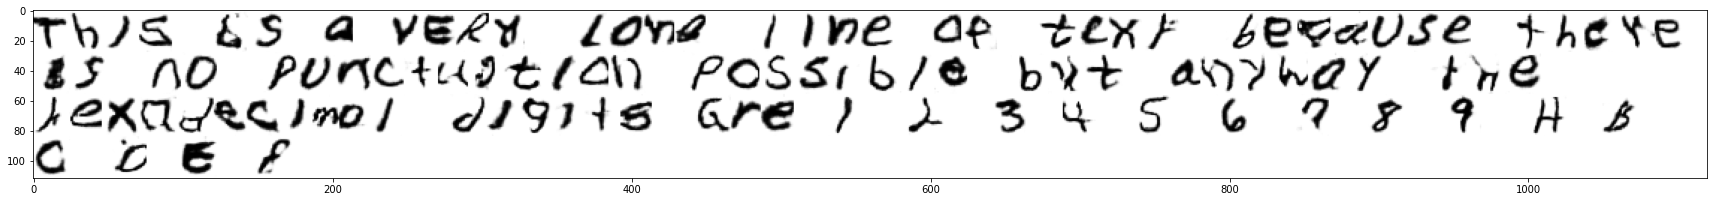

In [24]:
def get_text_lines(text, line_nchars, char_width, char_height, latent_dim, label_dict):
  words = text.split(' ')
  letter_imgs = [generate_word_images(w, latent_dim, label_dict) for w in words]
  word_imgs = [get_word(l) for l in letter_imgs]

  page = []
  line_width = line_nchars * char_width
  line = word_imgs[0]  
  current_word = 1
  while current_word < len(word_imgs):
    ws = get_wspace(char_height, char_width, int(0.2*char_width))
    img = word_imgs[current_word]

    if len(line[0]) + len(ws[0]) + len(img[0]) <= line_width: # fits in a line
      line = np.hstack((line, ws, img))
    else:
      line = np.hstack((line, np.zeros((char_height, line_width-len(line[0])))))  # complete the length
      page.append(np.copy(line))
      line = word_imgs[current_word]  # next line

    current_word += 1

  line = np.hstack((line, np.zeros((char_height, line_width-len(line[0])))))  # last line
  page.append(line)

  text_lines = np.vstack(page)
  return text_lines
  
text = 'This is a VERY long line of text because there is no punctuation possible but anyway the hexadecimal digits are 1 2 3 4 5 6 7 8 9 A B C D E F'

tl = get_text_lines(text, 40, 28, 28, latent_dim, balanced_dict)
tl.shape

fig = plt.figure(figsize=(30, 20))
plt.imshow(tl, cmap = 'gray_r')